+ 数据源 [腾讯疫情实时追踪](https://news.qq.com/zt2020/page/feiyan.htm?from=timeline&isappinstalled=0)

### 第一部分 网页分析

今天重新整理了一下，发现数据结构和之前的有所变化，把具体的操作步骤也说一下吧！
打开网址推荐使用火狐浏览器，F12 进入开发者工具（刷新一下页面），如下：

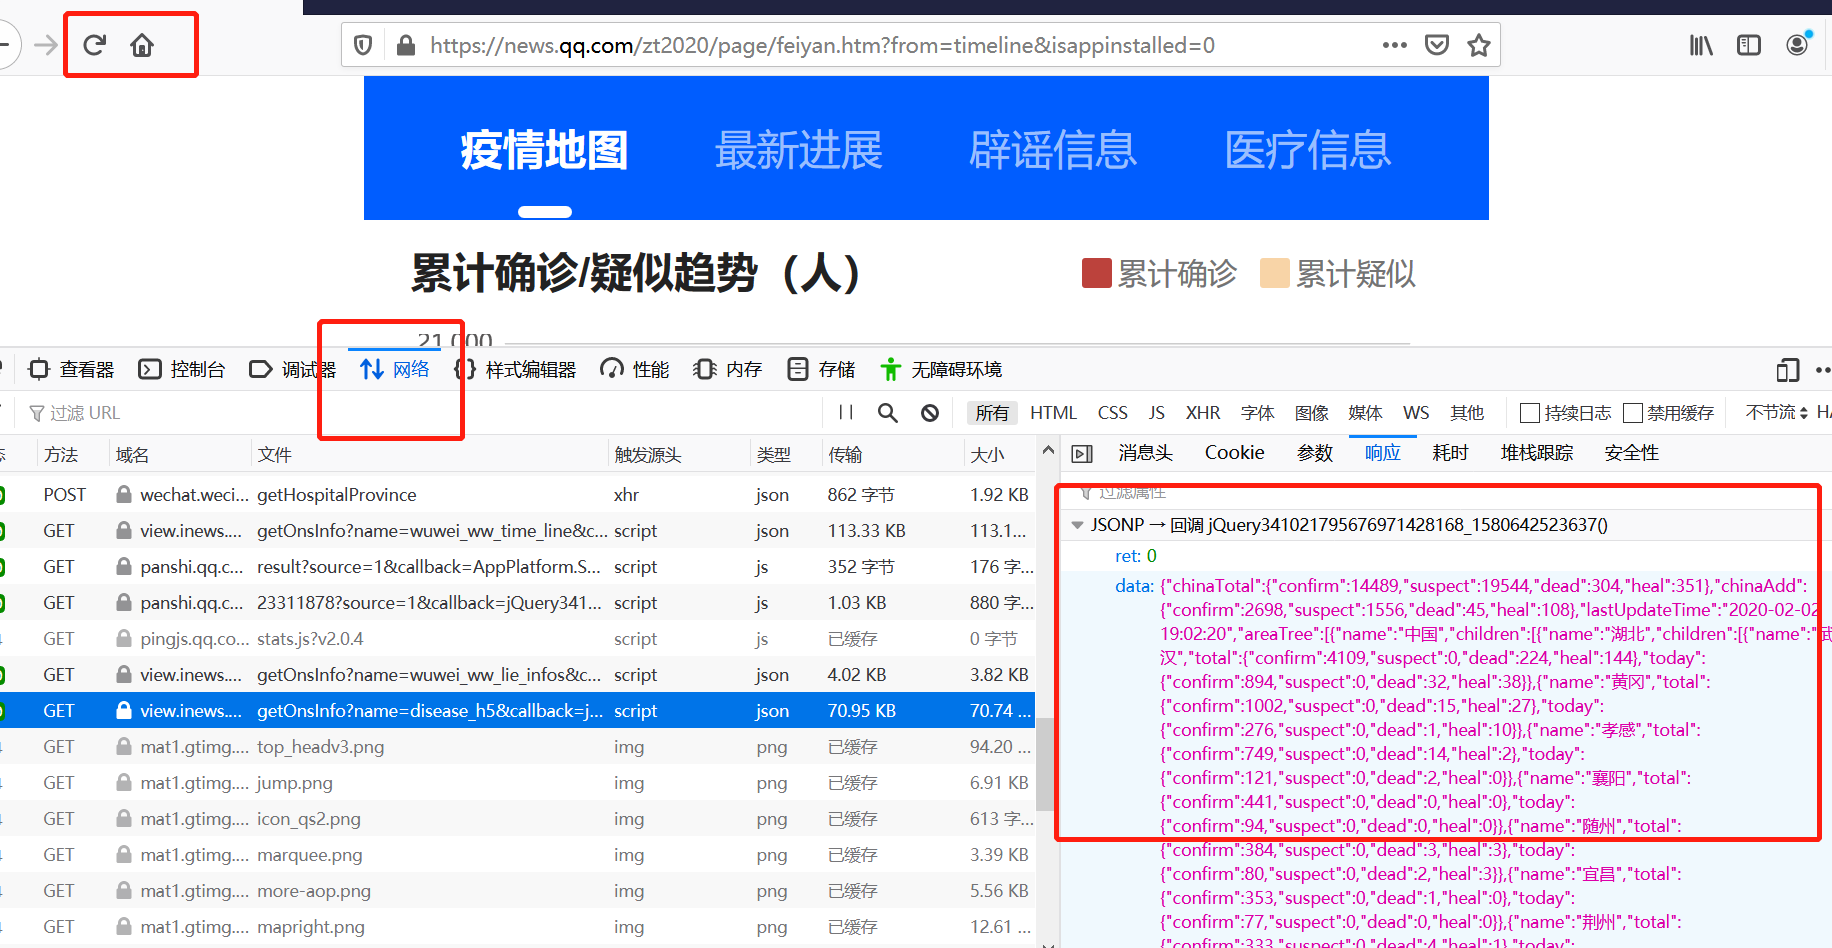

分析请求头
- name=disease_h5 是数据位置
- callback=jQuery341021795676971428168_1580642523637_=1580642523638返回当前时间戳的一个函数
所以我们请求的URL为：https://view.inews.qq.com/g2/getOnsInfo?name=disease_h5
（自己尝试一下，这里需要找规律）
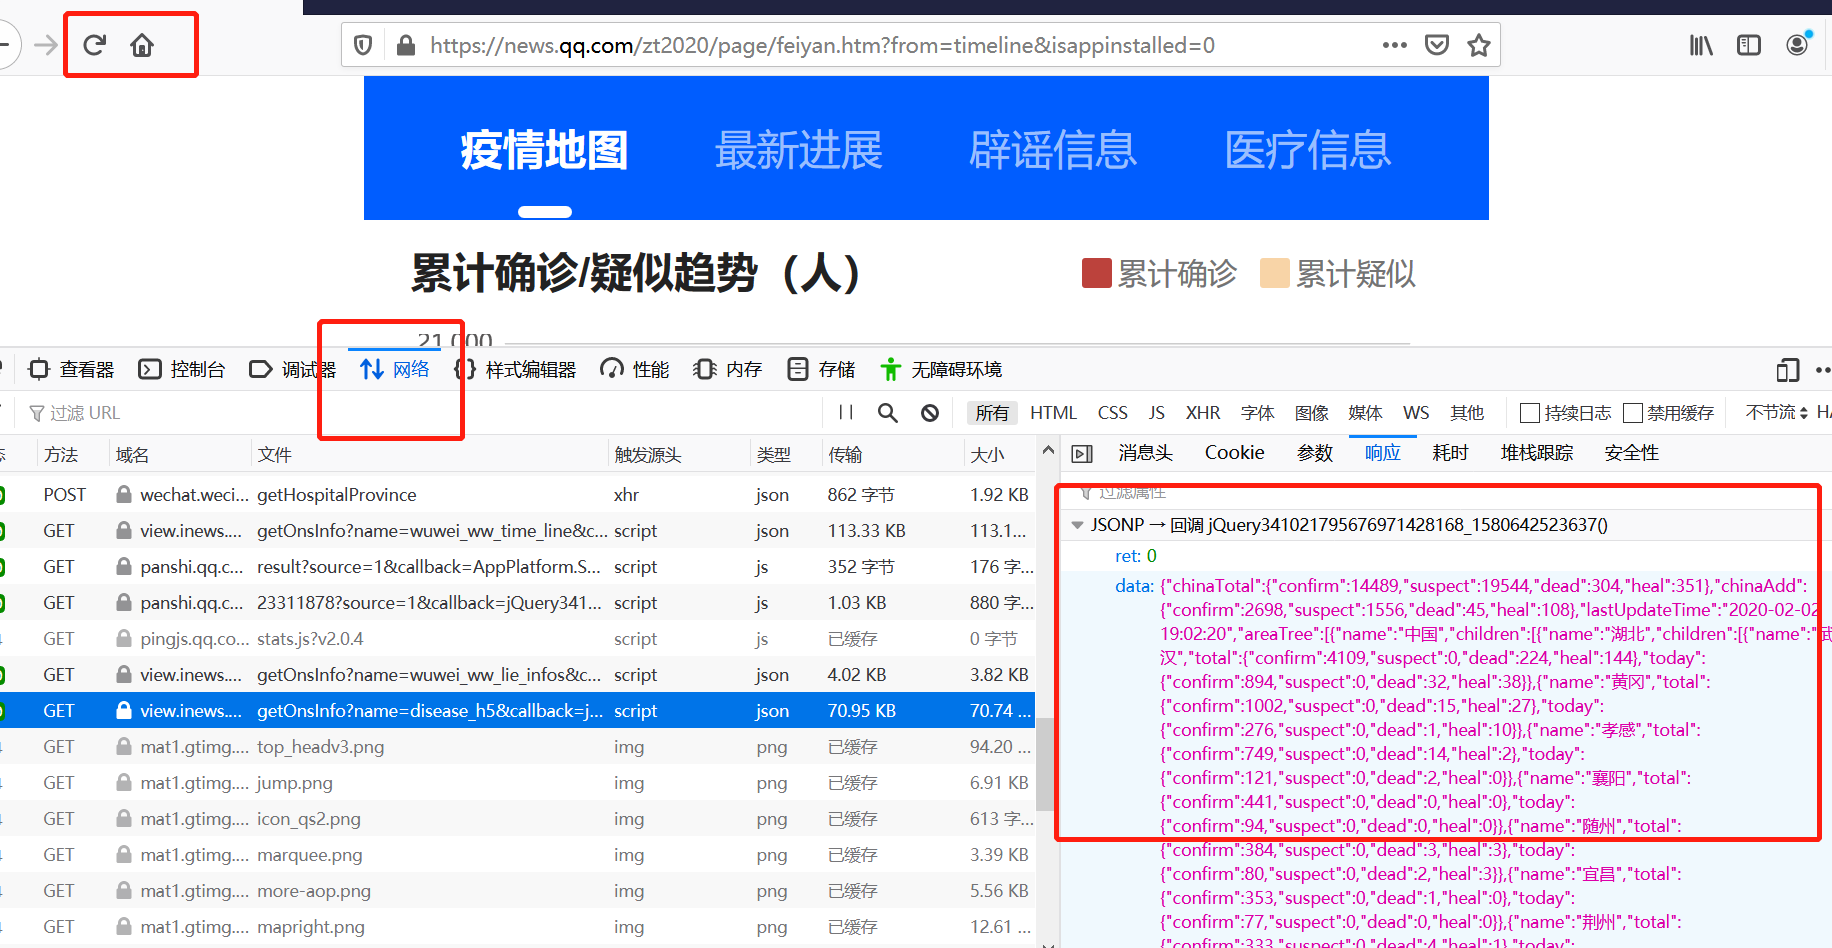

### 第二部分 数据准备

#### 导入模块

In [165]:
import time 
import json
import requests
from datetime import datetime
import pandas as pd 
import numpy as np 

#### 抓取数据

In [166]:
def catch_data():
    url = 'https://view.inews.qq.com/g2/getOnsInfo?name=disease_h5'
    reponse = requests.get(url=url).json()
    #返回数据字典
    data = json.loads(reponse['data'])
    return data

In [167]:
data = catch_data()
data.keys()

dict_keys(['chinaTotal', 'chinaAdd', 'lastUpdateTime', 'areaTree', 'chinaDayList', 'chinaDayAddList'])

#### 数据处理

In [168]:
# 数据集包括["国内总量","国内新增","更新时间","数据明细","每日数据","每日新增"]

lastUpdateTime = data['lastUpdateTime']
chinaTotal = data['chinaTotal']
chinaAdd = data['chinaAdd']
print(chinaTotal)
print(chinaAdd)

{'confirm': 17238, 'suspect': 21558, 'dead': 361, 'heal': 475}
{'confirm': 2858, 'suspect': 2014, 'dead': 57, 'heal': 147}


##### 国内数据处理 第一步

In [169]:
# 数据明细，数据结构比较复杂，一步一步打印出来看，先明白数据结构
areaTree = data['areaTree']
# 国内数据
china_data = areaTree[0]['children']
china_list = []
for a in range(len(china_data)):
    province = china_data[a]['name']
    province_list = china_data[a]['children']
    for b in range(len(province_list)):
        city = province_list[b]['name']
        total = province_list[b]['total']
        today = province_list[b]['today']
        china_dict = {}
        china_dict['province'] = province
        china_dict['city'] = city
        china_dict['total'] = total
        china_dict['today'] = today
        china_list.append(china_dict)
        
china_data = pd.DataFrame(china_list)
china_data.head()

,city,province,today,total
0,武汉,湖北,"{'confirm': 1033, 'suspect': 0, 'dead': 41, 'h...","{'confirm': 5142, 'suspect': 0, 'dead': 265, '..."
1,黄冈,湖北,"{'confirm': 244, 'suspect': 0, 'dead': 2, 'hea...","{'confirm': 1246, 'suspect': 0, 'dead': 17, 'h..."
2,孝感,湖北,"{'confirm': 169, 'suspect': 0, 'dead': 0, 'hea...","{'confirm': 918, 'suspect': 0, 'dead': 14, 'he..."
3,襄阳,湖北,"{'confirm': 107, 'suspect': 0, 'dead': 0, 'hea...","{'confirm': 548, 'suspect': 0, 'dead': 0, 'hea..."
4,荆州,湖北,"{'confirm': 166, 'suspect': 0, 'dead': 2, 'hea...","{'confirm': 499, 'suspect': 0, 'dead': 6, 'hea..."


##### 国内数据处理 第二步

In [170]:
# 定义数据处理函数
def confirm(x):
    confirm = eval(str(x))['confirm']
    return confirm
def suspect(x):
    suspect = eval(str(x))['suspect']
    return suspect
def dead(x):
    dead = eval(str(x))['dead']
    return dead
def heal(x):
    heal =  eval(str(x))['heal']
    return heal
# 函数映射
china_data['confirm'] = china_data['total'].map(confirm)
china_data['suspect'] = china_data['total'].map(suspect)
china_data['dead'] = china_data['total'].map(dead)
china_data['heal'] = china_data['total'].map(heal)
china_data['addconfirm'] = china_data['today'].map(confirm)
china_data['addsuspect'] = china_data['today'].map(suspect)
china_data['adddead'] = china_data['today'].map(dead)
china_data['addheal'] = china_data['today'].map(heal)
china_data = china_data[["province","city","confirm","suspect","dead","heal","addconfirm","addsuspect","adddead","addheal"]]
china_data.head()

,province,city,confirm,suspect,dead,heal,addconfirm,addsuspect,adddead,addheal
0,湖北,武汉,5142,0,265,181,1033,0,41,0
1,湖北,黄冈,1246,0,17,27,244,0,2,0
2,湖北,孝感,918,0,14,2,169,0,0,0
3,湖北,襄阳,548,0,0,0,107,0,0,0
4,湖北,荆州,499,0,6,1,166,0,2,0


##### 国际数据处理

In [171]:
global_data = pd.DataFrame(data['areaTree'])
global_data['confirm'] = global_data['total'].map(confirm)
global_data['suspect'] = global_data['total'].map(suspect)
global_data['dead'] = global_data['total'].map(dead)
global_data['heal'] = global_data['total'].map(heal)
global_data['addconfirm'] = global_data['today'].map(confirm)
global_data['addsuspect'] = global_data['today'].map(suspect)
global_data['adddead'] = global_data['today'].map(dead)
global_data['addheal'] = global_data['today'].map(heal)
world_name = pd.read_excel("世界各国中英文对照.xlsx")
global_data = pd.merge(global_data,world_name,left_on ="name",right_on = "中文",how="inner")
global_data = global_data[["name","英文","confirm","suspect","dead","heal","addconfirm","addsuspect","adddead","addheal"]]
global_data.head()

,name,英文,confirm,suspect,dead,heal,addconfirm,addsuspect,adddead,addheal
0,中国,China,17219,0,361,480,2732,0,57,53
1,日本,Japan,20,0,0,1,0,0,0,0
2,泰国,Thailand,19,0,0,7,0,0,0,0
3,新加坡,Singapore,18,0,0,0,0,0,0,0
4,韩国,Korea(republic of),15,0,0,0,0,0,0,0


##### 日数据处理

In [172]:
chinaDayList = pd.DataFrame(data['chinaDayList'])
chinaDayList = chinaDayList[['date','confirm','suspect','dead','heal']]
chinaDayList.head()

,date,confirm,suspect,dead,heal
0,01.13,41,0,1,0
1,01.14,41,0,1,0
2,01.15,41,0,2,5
3,01.16,45,0,2,8
4,01.17,62,0,2,12


##### 日新增数据处理

In [173]:
chinaDayAddList = pd.DataFrame(data['chinaDayAddList'])
chinaDayAddList = chinaDayAddList[['date','confirm','suspect','dead','heal']]
chinaDayAddList.head()

,date,confirm,suspect,dead,heal
0,01.20,77,27,0,0
1,01.21,149,53,3,0
2,01.22,131,257,8,0
3,01.23,259,680,8,6
4,01.24,444,1118,16,3


### 数据可视化

#### 总数据明细

In [174]:
from pyecharts.charts import * #导入所有图表
from pyecharts import options as opts
#导入pyecharts的主题（如果不使用可以跳过）
from pyecharts.globals import ThemeType

In [175]:
total_pie = Pie(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS,width = '500px',height ='350px'))  #设置主题，和画布大小
total_pie.add("",[list(z) for z in zip(chinaTotal.keys(), chinaTotal.values())],
            center=["50%", "50%"], #图的位置
            radius=[50, 80])   #内外径大小
total_pie.set_global_opts(
            title_opts=opts.TitleOpts(title="全国总量",subtitle=("截止"+lastUpdateTime)))
total_pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{c}"))  #标签格式
total_pie.render_notebook()

In [176]:
totaladd_pie = Pie(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS,width = '500px',height ='350px'))  #设置主题，和画布大小
totaladd_pie.add("",[list(z) for z in zip(chinaAdd.keys(), chinaAdd.values())],
            center=["50%", "50%"],
            radius=[50, 80])
totaladd_pie.set_global_opts(
            title_opts=opts.TitleOpts(title="昨日新增"))
totaladd_pie.set_series_opts(label_opts=opts.LabelOpts(formatter="{c}"))  #标签格式
totaladd_pie.render_notebook()

#### 全球疫情热图

In [177]:
world_map = Map(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS))
world_map.add("",[list(z) for z in zip(list(global_data["英文"]), list(global_data["confirm"]))], "world",is_map_symbol_show=False)
world_map.set_global_opts(title_opts=opts.TitleOpts(title="2019_nCoV-世界疫情地图"),
                          visualmap_opts=opts.VisualMapOpts(is_piecewise=True,
                          pieces = [
                        {"min": 101 , "label": '>100'}, #不指定 max，表示 max 为无限大
                        {"min": 10, "max": 100, "label": '10-100'},
                        {"min": 0, "max": 9, "label": '0-9' }]))
world_map.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
world_map.render_notebook()

#### 中国疫情地图热图绘制

In [ ]:
#数据处理
area_data = china_data.groupby("province")["confirm"].sum().reset_index()
area_data.columns = ["province","confirm"]

In [178]:
area_map = Map(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS))
area_map.add("",[list(z) for z in zip(list(area_data["province"]), list(area_data["confirm"]))], "china",is_map_symbol_show=False)
area_map.set_global_opts(title_opts=opts.TitleOpts(title="2019_nCoV中国疫情地图"),visualmap_opts=opts.VisualMapOpts(is_piecewise=True,
                pieces = [
                        {"min": 1001 , "label": '>1000',"color": "#893448"}, #不指定 max，表示 max 为无限大
                        {"min": 500, "max": 1000, "label": '500-1000',"color": "#ff585e"},
                        {"min": 101, "max": 499, "label": '101-499',"color": "#fb8146"},
                        {"min": 10, "max": 100, "label": '10-100',"color": "#ffb248"},
                        {"min": 0, "max": 9, "label": '0-9',"color" : "#fff2d1" }]))
area_map.render_notebook()

#### 绘制每日数据趋势

##### 每日累计数据趋势

In [186]:
line1 = Line(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS))
line1.add_xaxis(list(chinaDayList["date"]))
line1.add_yaxis("治愈",list(chinaDayList["heal"]),is_smooth=True)
line1.add_yaxis("死亡", list(chinaDayList["dead"]),is_smooth=True)
line1.set_global_opts(title_opts=opts.TitleOpts(title="Line1-治愈与死亡趋势"))
line1.render_notebook()

##### 每日累计确诊趋势

In [187]:
line2 = Line(init_opts=opts.InitOpts(theme=ThemeType.SHINE))
line2.add_xaxis(list(chinaDayList["date"]))
line2.add_yaxis("确诊",list(chinaDayList["confirm"]))
line2.add_yaxis("疑似", list(chinaDayList["suspect"]))
line2.set_global_opts(title_opts=opts.TitleOpts(title="Line2-确诊与疑似趋势"))
line2.render_notebook()

##### 每日新增

In [188]:
bar = Bar(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS,width = '900px',height ='400px'))
bar .add_xaxis(list(chinaDayAddList["date"]))
bar .add_yaxis("确诊", list(chinaDayAddList["confirm"]))
bar .add_yaxis("疑似", list(chinaDayAddList["suspect"]))
bar .add_yaxis("死亡", list(chinaDayAddList["dead"]))
bar .add_yaxis("治愈", list(chinaDayAddList["heal"]))
bar .set_global_opts(title_opts=opts.TitleOpts(title="每日新增数据趋势"))
bar.render_notebook()

### 图片汇总

In [194]:
page = Page()
page.add(total_pie)
page.add(totaladd_pie)
page.add(world_map)
page.add(area_map)
page.add(line1)
page.add(line2)
page.add(bar)
page.render("2019_nCoV 可视化.html")

'C:\\Users\\junhu\\Desktop\\2019_nCoV\\2019_nCoV 可视化.html'